# Final Run on SAS-KIIT

In [1]:
import os
import tensorflow as tf
import larq as lq
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

csv_path = r"C:\Users\KIIT\Documents\mel_spectrograms_sas-kiit\mel_spectrogram_sas-kiit_metadata.csv"
image_base_path = r"C:\Users\KIIT\Documents\mel_spectrograms_sas-kiit"

df = pd.read_csv(csv_path)

class_mapping = {row['classID']: row['class_name'] for _, row in df.iterrows()}

sorted_class_ids = sorted(class_mapping.keys())

class_to_index = {class_id: i for i, class_id in enumerate(sorted_class_ids)}

print("Class Mapping:", class_to_index)

num_classes = len(sorted_class_ids)
input_shape = (128, 128, 3)

def load_spectrogram_data(df, image_base_path):
    images = []
    labels = []
    
    for _, row in df.iterrows():
        img_path = os.path.join(image_base_path, row['mel_spectrogram_file'])

        if os.path.exists(img_path): 
            img = load_img(img_path, target_size=(128, 128))
            img = img_to_array(img) / 255.0  
            images.append(img)
            
            label = class_to_index[row['classID']]
            labels.append(label)
        else:
            print(f"Missing file: {img_path}")

    return np.array(images), np.array(labels)


X, y = load_spectrogram_data(df, image_base_path)


y = tf.keras.utils.to_categorical(y, num_classes=num_classes)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


kwargs = dict(
    input_quantizer="ste_sign",
    kernel_quantizer="ste_sign",
    kernel_constraint="weight_clip",
    use_bias=False
)

def create_bnn_model(input_shape, num_classes):
    model = Sequential([
        lq.layers.QuantConv2D(32, (3, 3), kernel_quantizer="ste_sign", kernel_constraint="weight_clip", use_bias=False, 
                              input_shape=input_shape, kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        lq.layers.QuantConv2D(64, (3, 3), **kwargs),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        lq.layers.QuantConv2D(128, (3, 3), **kwargs),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        lq.layers.QuantDense(128, **kwargs),
        BatchNormalization(),
        Dropout(0.5), # it was 0.6

        lq.layers.QuantDense(num_classes, **kwargs),
        BatchNormalization(),
        Activation("softmax")
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model


bnn_model = create_bnn_model(input_shape, num_classes)

bnn_model.summary()
lq.models.summary(bnn_model)

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import time

# Model Checkpoint
checkpoint = ModelCheckpoint("SAS-KIIT_best_spectrogram_bnn_model.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=3, 
                              verbose=1, 
                              min_lr=1e-6)

start_time = time.time()

history = bnn_model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    batch_size=16,
    callbacks=[checkpoint, reduce_lr]
)

end_time = time.time()
training_time = end_time - start_time
hours = training_time // 3600
minutes = (training_time % 3600) // 60
seconds = training_time % 60

print(f"Total training time: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds")
bnn_model.save("SAS-KIIT-lastrun_bnn_spectrogram_model.h5")

Class Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quant_conv2d (QuantConv2D)   (None, 126, 126, 32)      864       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
quant_conv2d_1 (QuantConv2D) (None, 61, 61, 64)        18432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPool

In [2]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = bnn_model.predict(X_val)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

report = classification_report(y_true_classes, y_pred_classes, target_names=[class_mapping[i] for i in sorted_class_ids])

print(report)


                          precision    recall  f1-score   support

                 Tanpura       1.00      1.00      1.00        88
        Traditional_Song       1.00      1.00      1.00        92
          Railway_Engine       0.97      1.00      0.98        90
    Children_class_noise       1.00      1.00      1.00       100
               Harmonium       0.97      1.00      0.98        84
                    Dhak       1.00      1.00      1.00        84
                   Tabla       1.00      0.98      0.99       106
                    Azan       1.00      1.00      1.00        74
           Church_Prayer       1.00      1.00      1.00        87
       Irrigation_Engine       0.94      1.00      0.97        92
                  Ektara       1.00      1.00      1.00        94
           Launch_Engine       1.00      1.00      1.00        96
                   Flute       1.00      1.00      1.00       100
         Bhuddist_Prayer       1.00      1.00      1.00        90
         

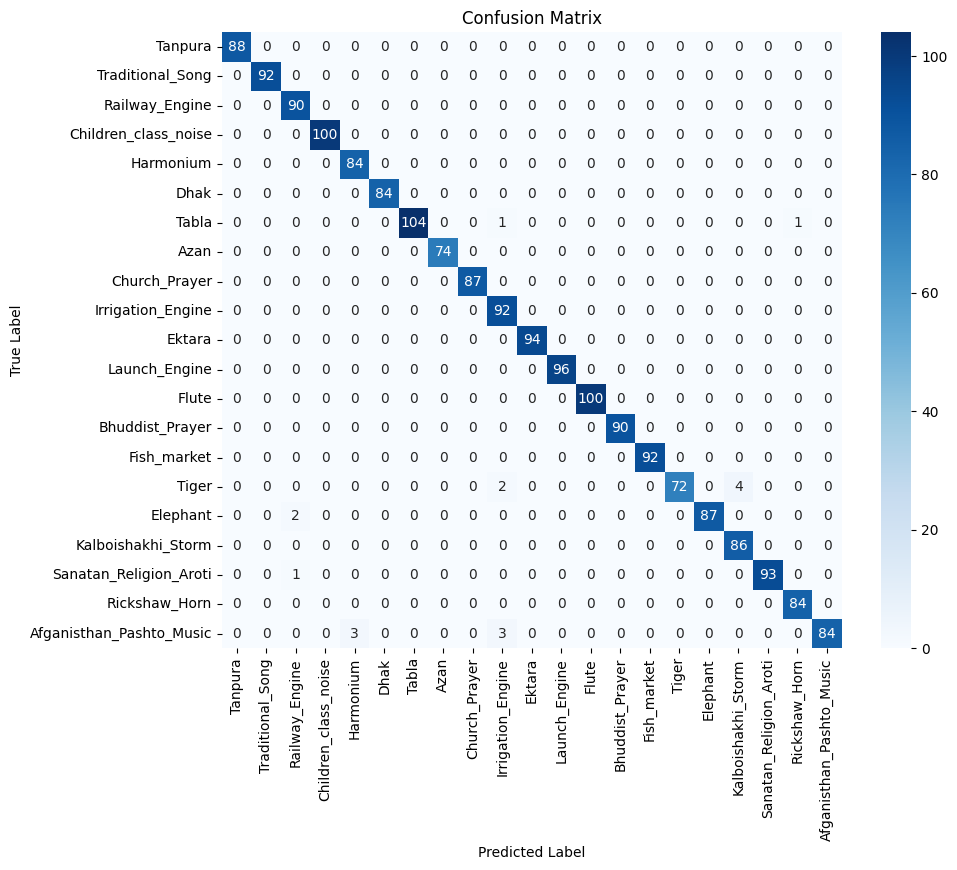

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = bnn_model.predict(X_val)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[class_mapping[i] for i in sorted_class_ids], 
            yticklabels=[class_mapping[i] for i in sorted_class_ids])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


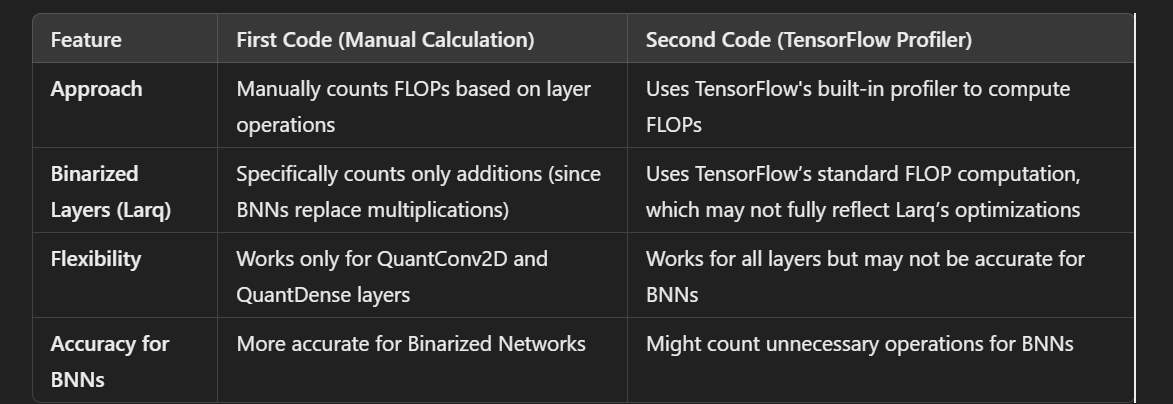

In [ ]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def get_flops(model, batch_size=1):
    try:
        concrete_func = tf.function(model).get_concrete_function(
            tf.TensorSpec([batch_size] + list(model.input_shape[1:]), model.inputs[0].dtype)
        )

        frozen_func = convert_variables_to_constants_v2(concrete_func)

        graph_def = frozen_func.graph.as_graph_def()

        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph, run_meta=run_meta, options=opts)
        
        return flops.total_float_ops
    except Exception as e:
        print("Error computing FLOPS:", e)
        return None

model = bnn_model  
flops = get_flops(model, batch_size=1)
if flops is not None:
    print(f"FLOPS: {flops / 10**9:.03f} G")


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 0.287 G


In [ ]:
import numpy as np
import tensorflow.keras.backend as K

def calculate_flops(model):
    total_flops = 0
    
    for layer in model.layers:
        if isinstance(layer, lq.layers.QuantConv2D):
            _, h, w, c_in = layer.input_shape
            c_out = layer.filters
            k_h, k_w = layer.kernel_size
            flops = h * w * c_in * c_out * k_h * k_w  
            total_flops += flops
        
        elif isinstance(layer, lq.layers.QuantDense):
            c_in = layer.input_shape[-1]
            c_out = layer.units

            flops = c_in * c_out  
            total_flops += flops

    return total_flops

flops = calculate_flops(bnn_model)

flops_in_g = flops / 1e9

print(f"Total FLOPs: {flops_in_g:.4f} G")


Total FLOPs: 0.1569 G


# SAS-KIIT CNN MOdel run

In [ ]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

csv_path = r"C:\Users\KIIT\Documents\mel_spectrograms_sas-kiit\mel_spectrogram_sas-kiit_metadata.csv"
image_base_path = r"C:\Users\KIIT\Documents\mel_spectrograms_sas-kiit"

df = pd.read_csv(csv_path)

class_mapping = {row['classID']: row['class_name'] for _, row in df.iterrows()}
sorted_class_ids = sorted(class_mapping.keys())
class_to_index = {class_id: i for i, class_id in enumerate(sorted_class_ids)}

print("Class Mapping:", class_to_index)

num_classes = len(sorted_class_ids)
input_shape = (128, 128, 3)

def load_spectrogram_data(df, image_base_path):
    images, labels = [], []
    
    for _, row in df.iterrows():
        img_path = os.path.join(image_base_path, row['mel_spectrogram_file'])

        if os.path.exists(img_path): 
            img = load_img(img_path, target_size=(128, 128))
            img = img_to_array(img) / 255.0  
            images.append(img)
            
            label = class_to_index[row['classID']]
            labels.append(label)
        else:
            print(f"Missing file: {img_path}")

    return np.array(images), np.array(labels)

X, y = load_spectrogram_data(df, image_base_path)

y = tf.keras.utils.to_categorical(y, num_classes=num_classes)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.0001), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

cnn_model = create_cnn_model(input_shape, num_classes)

cnn_model.summary()

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import time

checkpoint = ModelCheckpoint("SAS-KIIT_best_spectrogram_cnn_model.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=3, 
                              verbose=1, 
                              min_lr=1e-6)

start_time = time.time()

history = cnn_model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    batch_size=16,
    callbacks=[checkpoint, reduce_lr]
)

end_time = time.time()
training_time = end_time - start_time
hours, minutes, seconds = int(training_time // 3600), int((training_time % 3600) // 60), int(training_time % 60)

print(f"Total training time: {hours} hours, {minutes} minutes, {seconds} seconds")
cnn_model.save("SAS-KIIT-lastrun_cnn_spectrogram_model.h5")


Class Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPo

In [11]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = cnn_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        92
           2       1.00      1.00      1.00        90
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00        84
           5       1.00      1.00      1.00        84
           6       1.00      1.00      1.00       106
           7       1.00      1.00      1.00        74
           8       1.00      1.00      1.00        87
           9       1.00      1.00      1.00        92
          10       1.00      1.00      1.00        94
          11       1.00      1.00      1.00        96
          12       1.00      1.00      1.00       100
          13       1.00      1.00      1.00        90
          14       1.00      1.00      1.00        92
          15       0.97      1.00      0.99        78
          16       1.00      0.98      0.99        89
          17       1.00    

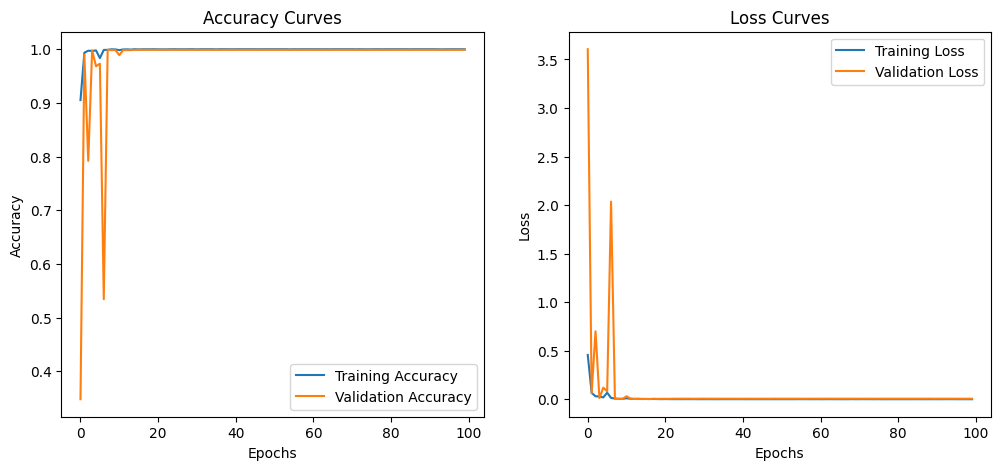

In [ ]:
import matplotlib.pyplot as plt
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    
    plt.show()

plot_training_curves(history)


In [ ]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def get_flops(model, batch_size=1):
    try:
        concrete_func = tf.function(model).get_concrete_function(
            tf.TensorSpec([batch_size] + list(model.input_shape[1:]), model.inputs[0].dtype)
        )

        frozen_func = convert_variables_to_constants_v2(concrete_func)

        graph_def = frozen_func.graph.as_graph_def()

        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph, run_meta=run_meta, options=opts)
        
        return flops.total_float_ops
    except Exception as e:
        print("Error computing FLOPS:", e)
        return None

model = cnn_model  
flops = get_flops(model, batch_size=1)
if flops is not None:
    print(f"FLOPS: {flops / 10**9:.03f} G")


FLOPS: 0.341 G


In [ ]:

import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def get_flops(model):
    concrete_func = tf.function(model).get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]), model.input.dtype)
    )
    
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph, run_meta=run_meta, options=opts)
    
    return flops.total_float_ops if flops is not None else None

cnn_flops = get_flops(cnn_model)


if cnn_flops is not None:
    print(f"Total FLOPs: {cnn_flops / 1e9:.4f} G")
else:
    print("Could not compute FLOPs.")


Total FLOPs: 0.3405 G


# SPRSound CNN model Run

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.0001), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model


input_shape = (128, 128, 3)
num_classes = 7 


model = create_cnn_model(input_shape, num_classes)


model.summary()

def calculate_model_size(model):
    total_params = model.count_params()
    trainable_params = sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_params = sum([K.count_params(p) for p in model.non_trainable_weights])

    total_size_mb = (total_params * 4) / (1024 ** 2)
    trainable_size_mb = (trainable_params * 4) / (1024 ** 2)
    non_trainable_size_kb = (non_trainable_params * 4) / 1024  

    print(f"Total params: {total_params} ({total_size_mb:.2f} MB)")
    print(f"Trainable params: {trainable_params} ({trainable_size_mb:.2f} MB)")
    print(f"Non-trainable params: {non_trainable_params} ({non_trainable_size_kb:.2f} KB)")

calculate_model_size(model)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)      

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = r'C:\Users\KIIT\Documents\final_SPRS\train'
val_dir = r'C:\Users\KIIT\Documents\final_SPRS\val'


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,    
    width_shift_range=0.2,  
    height_shift_range=0.2,
    shear_range=0.2,        
    zoom_range=0.2,        
    horizontal_flip=True, 
    fill_mode='nearest'    
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical'
)


Found 9768 images belonging to 7 classes.
Found 2445 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
checkpoint = ModelCheckpoint("sprsound_best_CNN_model.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=3, 
                              verbose=1, 
                              min_lr=1e-6)

learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[checkpoint, reduce_lr] 
)

model.save("sprsound_best_cnn_spectrogram_model.h5")


Epoch 1/100
611/611 [==============================] - ETA: 0s - loss: 1.9040 - accuracy: 0.3501
Epoch 00001: val_accuracy improved from -inf to 0.67689, saving model to sprsound_best_CNN_model.h5
611/611 [==============================] - 416s 680ms/step - loss: 1.9040 - accuracy: 0.3501 - val_loss: 1.2405 - val_accuracy: 0.6769
Epoch 2/100
611/611 [==============================] - ETA: 0s - loss: 1.3502 - accuracy: 0.5612
Epoch 00002: val_accuracy did not improve from 0.67689
611/611 [==============================] - 403s 659ms/step - loss: 1.3502 - accuracy: 0.5612 - val_loss: 1.1581 - val_accuracy: 0.6119
Epoch 3/100
611/611 [==============================] - ETA: 0s - loss: 0.9808 - accuracy: 0.7013
Epoch 00003: val_accuracy improved from 0.67689 to 0.78078, saving model to sprsound_best_CNN_model.h5
611/611 [==============================] - 504s 825ms/step - loss: 0.9808 - accuracy: 0.7013 - val_loss: 0.8122 - val_accuracy: 0.7808
Epoch 4/100
611/611 [=========================

153/153 [==============================] - 15s 96ms/step


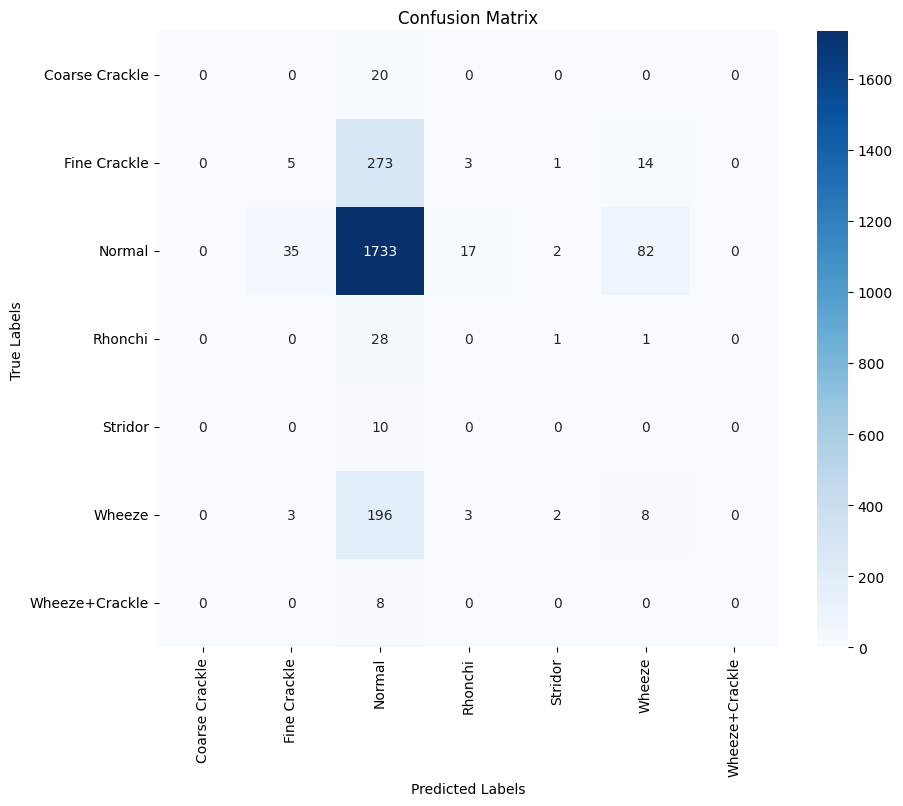

Classification Report:
                precision    recall  f1-score   support

Coarse Crackle       0.00      0.00      0.00        20
  Fine Crackle       0.12      0.02      0.03       296
        Normal       0.76      0.93      0.84      1869
       Rhonchi       0.00      0.00      0.00        30
       Stridor       0.00      0.00      0.00        10
        Wheeze       0.08      0.04      0.05       212
Wheeze+Crackle       0.00      0.00      0.00         8

      accuracy                           0.71      2445
     macro avg       0.14      0.14      0.13      2445
  weighted avg       0.60      0.71      0.65      2445

Validation Accuracy: 71.41%


C:\Users\KIIT\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KIIT\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KIIT\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

val_predictions = model.predict(val_generator, verbose=1)
val_true_labels = val_generator.classes

predicted_labels = np.argmax(val_predictions, axis=1)

cm = confusion_matrix(val_true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_generator.class_indices, yticklabels=val_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(val_true_labels, predicted_labels, target_names=val_generator.class_indices.keys()))

accuracy = np.sum(predicted_labels == val_true_labels) / len(val_true_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


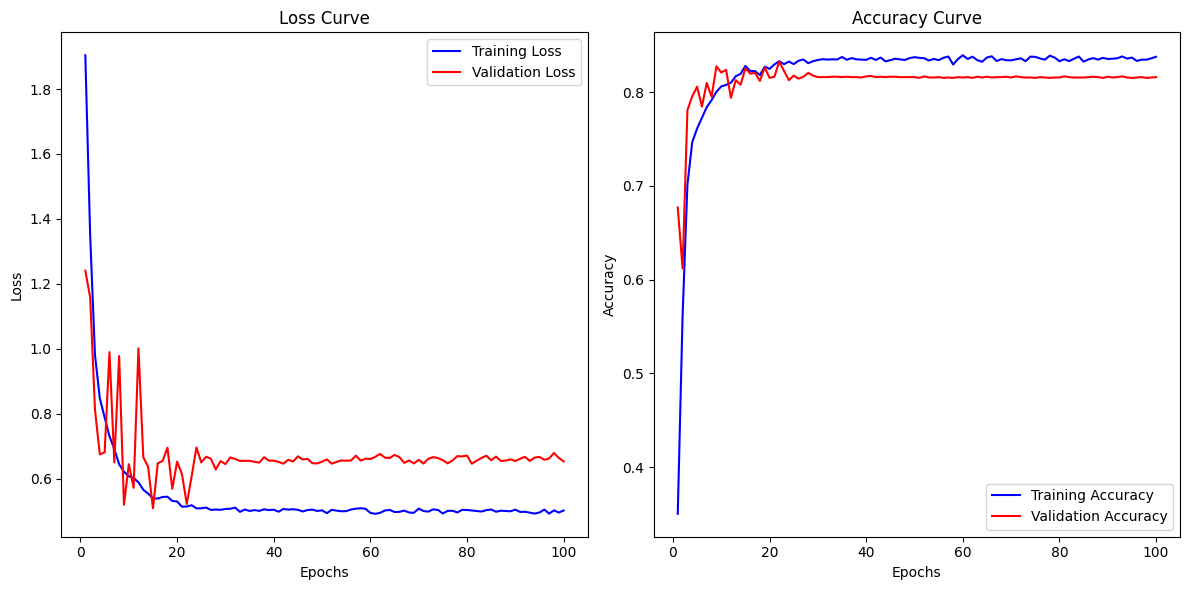

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) 
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='red')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2) 
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy', color='blue')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy', color='red')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def get_flops(model, batch_size=1):
    try:
        concrete_func = tf.function(model).get_concrete_function(
            tf.TensorSpec([batch_size] + list(model.input_shape[1:]), model.inputs[0].dtype)
        )
        frozen_func = convert_variables_to_constants_v2(concrete_func)

        graph_def = frozen_func.graph.as_graph_def()

        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph, run_meta=run_meta, options=opts)
        
        return flops.total_float_ops
    except Exception as e:
        print("Error computing FLOPS:", e)
        return None

model1 = model  
flops = get_flops(model1, batch_size=1)
if flops is not None:
    print(f"FLOPS: {flops / 10**9:.03f} G")  


FLOPS: 0.341 G


In [ ]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def get_flops(model):
    concrete_func = tf.function(model).get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]), model.input.dtype)
    )
    
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph, run_meta=run_meta, options=opts)
    
    return flops.total_float_ops if flops is not None else None

cnn_flops2 = get_flops(model)

if cnn_flops2 is not None:
    print(f"Total FLOPs: {cnn_flops2 / 1e9:.4f} G")
else:
    print("Could not compute FLOPs.")


Total FLOPs: 0.3405 G


# SPRSOUND BCNN run

In [ ]:
lq.models.summary(bnn_model)

In [ ]:
import tensorflow as tf
import larq as lq
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

kwargs = dict(
    input_quantizer="ste_sign",
    kernel_quantizer="ste_sign",
    kernel_constraint="weight_clip",
    use_bias=False
)

def create_bnn_model(input_shape, num_classes):
    model = Sequential([
        lq.layers.QuantConv2D(32, (3, 3), kernel_quantizer="ste_sign", kernel_constraint="weight_clip", use_bias=False, input_shape=input_shape,kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        lq.layers.QuantConv2D(64, (3, 3), **kwargs),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        lq.layers.QuantConv2D(128, (3, 3), **kwargs),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        lq.layers.QuantDense(128, **kwargs),
        BatchNormalization(),
        Dropout(0.6),

        lq.layers.QuantDense(num_classes, **kwargs),
        BatchNormalization(),
        Activation("softmax")
    ])

    
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

def calculate_bnn_model_size(model):
    total_params = model.count_params()
    trainable_params = sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_params = sum([K.count_params(p) for p in model.non_trainable_weights])

    binary_params = 0
    float_params = 0

    for layer in model.layers:
        if isinstance(layer, (lq.layers.QuantConv2D, lq.layers.QuantDense)):
            binary_params += layer.count_params() 
        else:
            float_params += sum([K.count_params(p) for p in layer.trainable_weights]) 

    binary_size_mb = (binary_params / 8) / (1024 ** 2)  
    float_size_mb = (float_params * 4) / (1024 ** 2)  
    non_trainable_size_kb = (non_trainable_params * 4) / 1024 

    total_size_mb = binary_size_mb + float_size_mb + (non_trainable_size_kb / 1024)

    print(f"Total params: {total_params} ({total_size_mb:.2f} MB)")
    print(f"Binary trainable params: {binary_params} ({binary_size_mb:.2f} MB)")
    print(f"Float32 trainable params: {float_params} ({float_size_mb:.2f} MB)")
    print(f"Non-trainable params: {non_trainable_params} ({non_trainable_size_kb:.2f} KB)")

input_shape = (224, 224, 3)
num_classes = 7  

sprs_bnn_model = create_bnn_model(input_shape, num_classes)

bnn_model.summary()
lq.models.summary(sprs_bnn_model)

calculate_bnn_model_size(sprs_bnn_model)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quant_conv2d (QuantConv2D)   (None, 126, 126, 32)      864       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
quant_conv2d_1 (QuantConv2D) (None, 61, 61, 64)        18432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
quant_conv2d_2 (QuantConv2D) (None, 28, 28, 128)       7

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = r'C:\Users\KIIT\Documents\final_SPRS\train'
val_dir = r'C:\Users\KIIT\Documents\final_SPRS\val'

train_datagen = ImageDataGenerator(
    rescale=1./255,       
    rotation_range=20,     
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2,       
    zoom_range=0.2,        
    horizontal_flip=True,   
    fill_mode='nearest'     
)

val_datagen = ImageDataGenerator(rescale=1./255) 
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 9768 images belonging to 7 classes.
Found 2445 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import time

checkpoint = ModelCheckpoint("best_sprs_bnn_model.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=5, 
                              verbose=1, 
                              min_lr=1e-6)

learning_rate = 0.0001

sprs_bnn_model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

start_time = time.time()
history = sprs_bnn_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[checkpoint, reduce_lr] 
)

end_time = time.time()
training_time = end_time - start_time
hours = training_time // 3600
minutes = (training_time % 3600) // 60
seconds = training_time % 60

print(f"Total training time: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds")
bnn_model.save("sprs_bnn_spectrogram_model.h5")


Epoch 1/100
306/306 [==============================] - ETA: 0s - loss: 2.0612 - accuracy: 0.1896
Epoch 00001: val_accuracy improved from -inf to 0.67566, saving model to best_sprs_bnn_model.h5
306/306 [==============================] - 1056s 3s/step - loss: 2.0612 - accuracy: 0.1896 - val_loss: 1.1768 - val_accuracy: 0.6757
Epoch 2/100
306/306 [==============================] - ETA: 0s - loss: 1.9253 - accuracy: 0.2951
Epoch 00002: val_accuracy did not improve from 0.67566
306/306 [==============================] - 1059s 3s/step - loss: 1.9253 - accuracy: 0.2951 - val_loss: 1.6554 - val_accuracy: 0.5333
Epoch 3/100
306/306 [==============================] - ETA: 0s - loss: 1.8512 - accuracy: 0.3490
Epoch 00003: val_accuracy improved from 0.67566 to 0.68834, saving model to best_sprs_bnn_model.h5
306/306 [==============================] - 1056s 3s/step - loss: 1.8512 - accuracy: 0.3490 - val_loss: 1.0901 - val_accuracy: 0.6883
Epoch 4/100
306/306 [==============================] - ETA: 